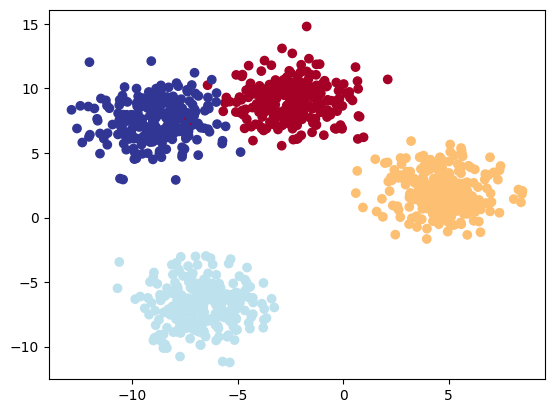

In [60]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2

# 1. Create multi-class data
X, y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=42
)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class NNModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(input_features, hidden_units),
      #nn.ReLU(),    #->Not needed
      nn.Linear(hidden_units, hidden_units),
     # nn.ReLU(),   #-> Not needed
      nn.Linear(hidden_units, output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)
model = NNModel(input_features=2, output_features=4)
model

NNModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [62]:
loss_fn = nn.CrossEntropyLoss() # !!! WEIGHT CAN BE USED AS A PARAM TO SPECIFY IF THE DATASET IS UNBALANCED!!
optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1)
y_logits = model(X_train)
y_pred_probs = torch.softmax(y_logits, dim = 1) #turns logits into actual probabilities
y_preds = torch.argmax(y_pred_probs, dim = 1) #take the max value
y_logits, y_pred_probs, torch.sum(y_pred_probs[0]) , y_preds

(tensor([[ 1.1238,  0.8200,  1.3206, -0.5335],
         [ 0.1099,  0.7413, -0.1961,  0.2668],
         [ 0.2379,  0.3103,  0.1675, -0.7798],
         ...,
         [-0.9779,  0.4318, -1.7355,  0.6428],
         [ 0.6590,  0.8711,  0.5912,  0.0204],
         [ 0.6245,  0.5238,  0.6742, -0.6915]], grad_fn=<AddmmBackward0>),
 tensor([[0.3178, 0.2346, 0.3870, 0.0606],
         [0.2089, 0.3928, 0.1538, 0.2444],
         [0.2969, 0.3192, 0.2767, 0.1073],
         ...,
         [0.0942, 0.3856, 0.0441, 0.4761],
         [0.2703, 0.3342, 0.2527, 0.1428],
         [0.3102, 0.2805, 0.3261, 0.0832]], grad_fn=<SoftmaxBackward0>),
 tensor(1., grad_fn=<SumBackward0>),
 tensor([2, 1, 1, 1, 2, 1, 3, 2, 2, 1, 2, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 2, 2,
         1, 3, 3, 2, 1, 2, 1, 1, 3, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1, 3,
         0, 3, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 3, 2, 3, 2, 3, 2, 2, 2, 1, 2, 1, 1,
         2, 1, 1, 3, 3, 2, 2, 3, 3, 1, 1, 1, 2, 2, 1, 3, 3, 1, 2, 1, 1, 1, 2, 3,
         0, 2

In [63]:
def accuracy_fn(y_true, y_pred):
  count = torch.eq(y_true, y_pred).sum().item()
  return (count/len(y_pred))*100
epochs = 100
for epoch in range(epochs):
  model.train()
  y_logits = model(X_train)
  y_pred = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_pred = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
    if epoch%10 == 0:
      print(f"Loss: {loss}, Accuracy: {acc}, Test_loss: {test_loss}, Test_acc: {test_acc}")

Loss: 1.8580282926559448, Accuracy: 16.125, Test_loss: 0.6679962277412415, Test_acc: 75.5
Loss: 0.17549166083335876, Accuracy: 99.0, Test_loss: 0.1366579383611679, Test_acc: 100.0
Loss: 0.09393065422773361, Accuracy: 99.125, Test_loss: 0.07096841931343079, Test_acc: 100.0
Loss: 0.06671776622533798, Accuracy: 99.125, Test_loss: 0.04735758900642395, Test_acc: 100.0
Loss: 0.05383724346756935, Accuracy: 99.125, Test_loss: 0.035982534289360046, Test_acc: 100.0
Loss: 0.04655034840106964, Accuracy: 99.125, Test_loss: 0.02944193407893181, Test_acc: 100.0
Loss: 0.04194075986742973, Accuracy: 99.25, Test_loss: 0.025237204506993294, Test_acc: 100.0
Loss: 0.03879628702998161, Accuracy: 99.25, Test_loss: 0.022321179509162903, Test_acc: 100.0
Loss: 0.036532189697027206, Accuracy: 99.25, Test_loss: 0.020185548812150955, Test_acc: 100.0
Loss: 0.0348346009850502, Accuracy: 99.25, Test_loss: 0.018556153401732445, Test_acc: 100.0


helper_functions.py already exists, skipping download


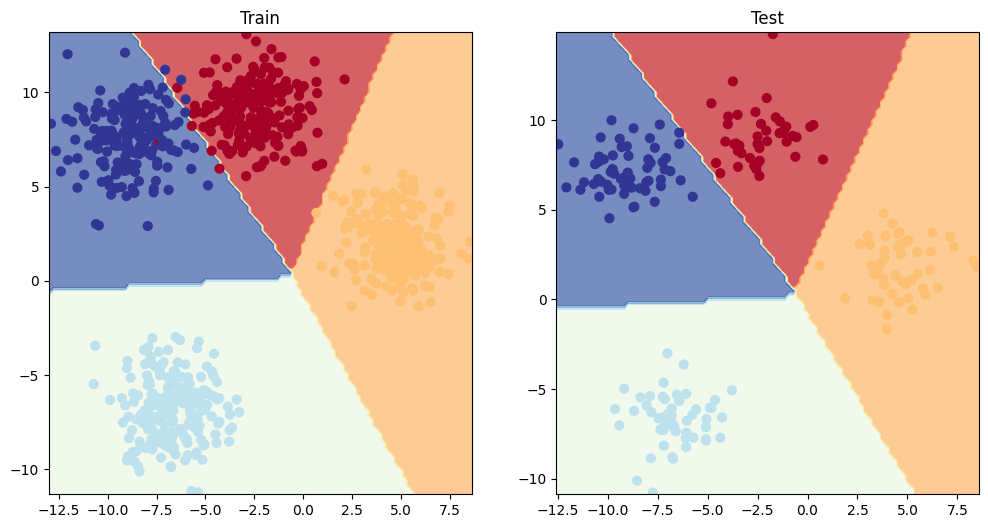

In [64]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test) # model_3 = has non-linearity